/Users/28zhany/promptforest/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running PromptForest uncertainty benchmark...


100%|██████████| 500/500 [00:51<00:00,  9.72it/s]

Total Samples: 500
Accuracy: 0.8020


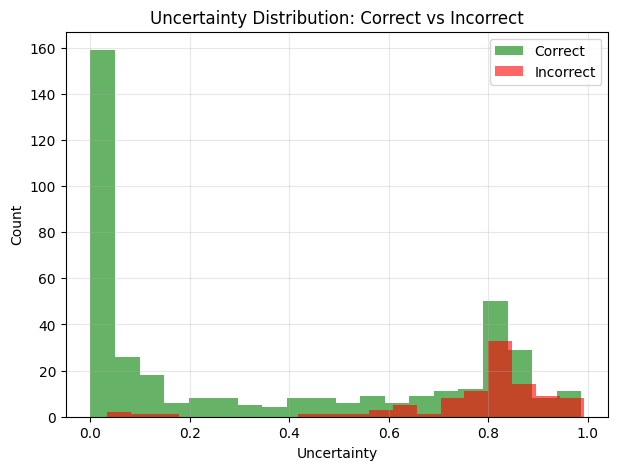

Mean uncertainty (correct): 0.34860115914499773
Mean uncertainty (incorrect): 0.7813650319386205


In [1]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
from tqdm import tqdm

# --- CONFIG ---
PF_SERVER_URL = "http://localhost:1000/analyze"
MAX_SAMPLES = 500

# --- HELPER FUNCTIONS ---
def parse_label(value):
    if isinstance(value, int): return value
    if isinstance(value, str):
        v = value.lower()
        if v in ["jailbreak", "malicious", "unsafe", "attack", "injection", "1"]: return 1
        if v in ["benign", "safe", "legit", "0"]: return 0
    try: return int(value)
    except: return 0

def get_pf_outputs(text):
    try:
        resp = requests.post(PF_SERVER_URL, json={"prompt": text, "explain": False}, timeout=5)
        if resp.status_code == 200:
            data = resp.json()
            # Use is_malicious if present, else parse prediction
            if "is_malicious" in data:
                pred_label = int(data["is_malicious"])
            else:
                pred_label = parse_label(data.get("prediction", "benign"))
            uncertainty = data.get("uncertainty", None)
            return pred_label, uncertainty
    except Exception:
        pass
    return 0, None

# --- DATASET & INFERENCE ---
ds = load_dataset("qualifire/prompt-injections-benchmark", split="test")
ds = ds.shuffle(seed=42).select(range(min(len(ds), MAX_SAMPLES)))

results = []
print("Running PromptForest uncertainty benchmark...")

for ex in tqdm(ds):
    text = ex.get('text') or ex.get('prompt')
    if not text: continue
    label = parse_label(ex['label'])
    pred_label, uncertainty = get_pf_outputs(text)
    is_correct = (pred_label == label)
    results.append({
        "label": label,
        "prediction": pred_label,
        "uncertainty": uncertainty,
        "is_correct": is_correct
    })

df = pd.DataFrame(results)

# --- ANALYSIS ---
print(f"Total Samples: {len(df)}")
print(f"Accuracy: {df['is_correct'].mean():.4f}")

# Plot uncertainty for correct vs incorrect
plt.figure(figsize=(7,5))
plt.hist(df[df['is_correct']]['uncertainty'].dropna(), bins=20, alpha=0.6, label='Correct', color='green')
plt.hist(df[~df['is_correct']]['uncertainty'].dropna(), bins=20, alpha=0.6, label='Incorrect', color='red')
plt.xlabel('Uncertainty')
plt.ylabel('Count')
plt.title('Uncertainty Distribution: Correct vs Incorrect')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print('Mean uncertainty (correct):', df[df['is_correct']]['uncertainty'].mean())
print('Mean uncertainty (incorrect):', df[~df['is_correct']]['uncertainty'].mean())